# **Temporal Visualizations of Flight Delays in the US (2019-2023)**

**Name:** Jayanth Anala \\
**NetID:** ja4874

## **Link to Dashboards (Tableau Public)**

Link: https://tinyurl.com/2kyvbn79

## **Tools Used**

1. Python - Pandas, Matplotlib, Numpy
2. Tableau - Dashboards and Visualizations
3. Overleaf - Latex Documentation



## **Basic Answers from Stats**

**Total Scheduled Flights:** 3000000 from 2019 to 2023

**Cancelled Flights:** 76,947 \\
**Cancelled Flights(%):** 2.3% \\

**Delayed Flights:** 835,848 \\
**Delayed Flights (%):** 27.8% \\

**Avg Delay:** 49 mins




# Importing Packages and Dataset files


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re

Below is a helper function that imports raw data from the url provided, and returns the final dataframe.

In [2]:
def import_df(filename):
    df = pd.read_csv(filename)
    return df

delay_df = import_df("/content/drive/MyDrive/IV Datasets/flights_sample_3m.csv")
airport_df = import_df("/content/drive/MyDrive/IV Datasets/airport_data.csv")

# Understanding the Datasets

In [3]:
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   code       380 non-null    object 
 1   Latitude   380 non-null    float64
 2   Longitude  380 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.0+ KB


In [4]:
delay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64
 21  CANCELLA

In [5]:
# Data Range availability
print("\nDate Range:")
print("Start Date:", delay_df['FL_DATE'].min())
print("End Date:", delay_df['FL_DATE'].max())


Date Range:
Start Date: 2019-01-01
End Date: 2023-08-31


In [6]:
# Null or NA values in the dataset
print("Missing values in delay dataset:")
print(delay_df.isnull().sum())

print("\nMissing values in delay dataset:")
print(airport_df.isnull().sum())

Missing values in delay dataset:
FL_DATE                          0
AIRLINE                          0
AIRLINE_DOT                      0
AIRLINE_CODE                     0
DOT_CODE                         0
FL_NUMBER                        0
ORIGIN                           0
ORIGIN_CITY                      0
DEST                             0
DEST_CITY                        0
CRS_DEP_TIME                     0
DEP_TIME                     77615
DEP_DELAY                    77644
TAXI_OUT                     78806
WHEELS_OFF                   78806
WHEELS_ON                    79944
TAXI_IN                      79944
CRS_ARR_TIME                     0
ARR_TIME                     79942
ARR_DELAY                    86198
CANCELLED                        0
CANCELLATION_CODE          2920860
DIVERTED                         0
CRS_ELAPSED_TIME                14
ELAPSED_TIME                 86198
AIR_TIME                     86198
DISTANCE                         0
DELAY_DUE_CARRIER     

In [7]:
# Count of Flights by each airline in the dataset
print("\nFrequency of Delays by Reason:")
print(delay_df['AIRLINE'].value_counts())


Frequency of Delays by Reason:
AIRLINE
Southwest Airlines Co.                576470
Delta Air Lines Inc.                  395239
American Airlines Inc.                383106
SkyWest Airlines Inc.                 343737
United Air Lines Inc.                 254504
Republic Airline                      143107
Envoy Air                             121256
JetBlue Airways                       112844
Endeavor Air Inc.                     112463
PSA Airlines Inc.                     107050
Alaska Airlines Inc.                  100467
Spirit Air Lines                       95711
Mesa Airlines Inc.                     65012
Frontier Airlines Inc.                 64466
Allegiant Air                          52738
Hawaiian Airlines Inc.                 32114
Horizon Air                            20634
ExpressJet Airlines LLC d/b/a aha!     19082
Name: count, dtype: int64


# **Dataset Cleaning**



**1. Fixed all the airline names and removed any special characters.**

*ex: ExpressJet Airlines LLC d/b/a aha! to ExpressJet Airlines LLC*

In [8]:
delay_df['AIRLINE'] = delay_df['AIRLINE'].replace(r'd/b/a aha!', '', regex=True)

**2. Removed all the reduntant and columns with not so useful data**




> 1.   AIRLINE_DOT
2.   AIRLINE_CODE
3.  DOT_CODE
4. FL_NUMBER
5. CRS_DEP_TIME
6. TAXI_OUT
7. WHEELS_OFF
8. WHEELS_ON
9. TAXI_IN
10. CRS_ARR_TIME
11. CANCELLATION_CODE
12. CRS_ELAPSED_TIME









In [9]:
delay_df.drop(['AIRLINE_DOT', 'AIRLINE_CODE','DOT_CODE', 'FL_NUMBER', 'CRS_DEP_TIME','TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN','CRS_ARR_TIME','CANCELLATION_CODE','CRS_ELAPSED_TIME'], axis=1, inplace=True)

**3. Removed the columns with Null Arrival Times**

> We had over 79942 rows in which arrival time is not filled, which makes them not useable for our study. So, we'll remove them

In [10]:
delay_df = delay_df.dropna(subset=['ARR_TIME'])

In [11]:
delay_df['ARR_TIME'] = delay_df['ARR_TIME'] // 100
delay_df['DEP_TIME'] = delay_df['DEP_TIME'] // 100

# **Data Aggregation**

**1. Adding Total delay times column based on all types of delays**



In [14]:
delay_df['total_delay_time'] = delay_df[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']].sum(axis=1)

**2. Categorizing the type of delay based on the arrival times**

In [15]:
def categorize_delay(delay,cancel):
    if delay < 0:
        return 'Early'
    elif delay == 0:
        return 'On-time'
    elif delay > 0:
        return 'Delayed'
    elif cancel == 1:
        return 'Cancelled'
    else:
        return 'Diverted'

delay_df['ARR_Type'] = delay_df.apply(lambda x: categorize_delay(x['ARR_DELAY'], x['CANCELLED']), axis=1)

**3. Categorizing the Delay Reason of delay based on the delay type**

In [16]:
def categorize_delay_reason(row):
    if row['DELAY_DUE_WEATHER'] > 0:
        return 'Weather'
    elif row['DELAY_DUE_NAS'] > 0:
        return 'NAS (National Airspace System)'
    elif row['DELAY_DUE_LATE_AIRCRAFT'] > 0:
        return 'Late Aircraft'
    elif row['DELAY_DUE_CARRIER'] > 0:
        return 'Carrier'
    elif row['DELAY_DUE_SECURITY'] > 0:
        return 'Security'
    elif row['CANCELLED'] > 0:
        return 'Cancelled'
    elif row['DIVERTED'] > 0:
        return 'Diverted'
    else:
        return 'On-Time'

delay_df['Delay_reason'] = delay_df.apply(categorize_delay_reason, axis=1)

**Understanding the dataset based on Delay Type**

In [22]:
delay_types_to_consider = ['Early']

filtered_df = delay_df[delay_df['ARR_Type'].isin(delay_types_to_consider)]
delay_counts = filtered_df['AIRLINE'].value_counts()
delay_counts = delay_counts.sort_values(ascending=False)

print(delay_counts)

AIRLINE
Southwest Airlines Co.      343480
Delta Air Lines Inc.        269612
American Airlines Inc.      233238
SkyWest Airlines Inc.       229173
United Air Lines Inc.       159435
Republic Airline             96299
Endeavor Air Inc.            82540
Envoy Air                    75644
PSA Airlines Inc.            67529
JetBlue Airways              63348
Alaska Airlines Inc.         60428
Spirit Air Lines             56129
Mesa Airlines Inc.           40621
Frontier Airlines Inc.       35839
Allegiant Air                27066
Hawaiian Airlines Inc.       17755
Horizon Air                  12606
ExpressJet Airlines LLC      11228
Name: count, dtype: int64


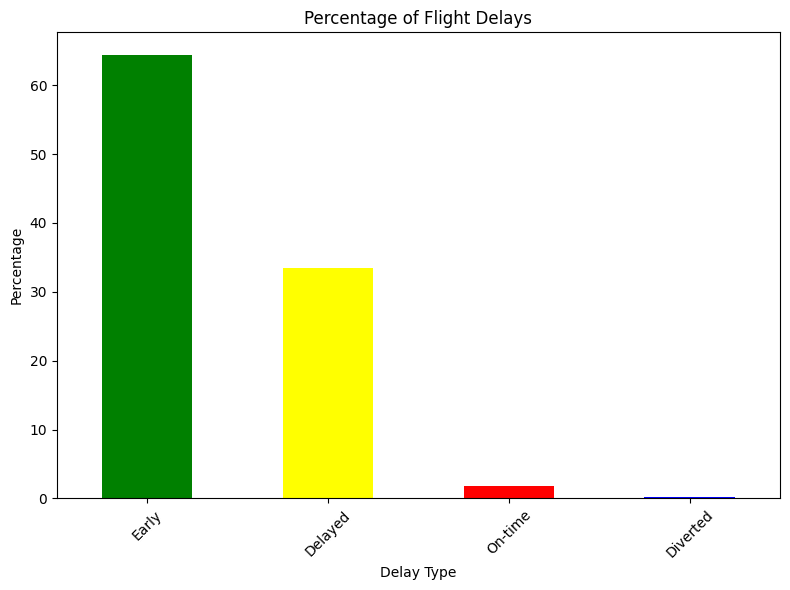

In [23]:
delay_counts = delay_df['ARR_Type'].value_counts()

# Calculate percentages
delay_percentages = (delay_counts / delay_counts.sum()) * 100

# Plotting
plt.figure(figsize=(8, 6))
delay_percentages.plot(kind='bar', color=['green', 'yellow', 'red', 'blue'])
plt.title('Percentage of Flight Delays')
plt.xlabel('Delay Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Datasets Merging**

In [24]:
# Merging the two datasets based on ORIGIN airport code
merged_df1 = pd.merge(delay_df, airport_df, left_on="ORIGIN", right_on="code", how="left")
merged_df1.drop(columns=["code"], inplace=True)
merged_df1.rename(columns={"Latitude": "origin_lat", "Longitude": "origin_lon"}, inplace=True)

# Merging the two datasets based on DEST airport code
merged_df2 = pd.merge(delay_df, airport_df, left_on="DEST", right_on="code", how="left")
merged_df2.drop(columns=["code"], inplace=True)
merged_df2.rename(columns={"Latitude": "destination_lat", "Longitude": "destination_lon"}, inplace=True)

# Combine the two merged dfs
delay_df = pd.concat([merged_df1, merged_df2[['destination_lat', 'destination_lon']]], axis=1)

# Splitting the State and City into two columns
delay_df[['ORIGIN_CITY', 'ORIGIN_STATE']] = delay_df['ORIGIN_CITY'].str.split(', ', expand=True)
delay_df[['DEST_CITY', 'DEST_STATE']] = delay_df['DEST_CITY'].str.split(', ', expand=True)

In [25]:
delay_df.head()

,FL_DATE,AIRLINE,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,...,DELAY_DUE_LATE_AIRCRAFT,total_delay_time,ARR_Type,Delay_reason,origin_lat,origin_lon,destination_lat,destination_lon,ORIGIN_STATE,DEST_STATE
0,2019-01-09,United Air Lines Inc.,FLL,Fort Lauderdale,EWR,Newark,11.0,-4.0,14.0,-14.0,...,NaN,0.0,Early,On-Time,26.0726,-80.1527,40.6925,-74.1687,FL,NJ
1,2022-11-19,Delta Air Lines Inc.,MSP,Minneapolis,SEA,Seattle,21.0,-6.0,23.0,-5.0,...,NaN,0.0,Early,On-Time,44.8820,-93.2218,47.4490,-122.3090,MN,WA
2,2022-07-22,United Air Lines Inc.,DEN,Denver,MSP,Minneapolis,10.0,6.0,12.0,0.0,...,NaN,0.0,On-time,On-Time,39.8617,-104.6730,44.8820,-93.2218,CO,MN
3,2023-03-06,Delta Air Lines Inc.,MSP,Minneapolis,SFO,San Francisco,16.0,-1.0,18.0,24.0,...,0.0,24.0,Delayed,NAS (National Airspace System),44.8820,-93.2218,37.6190,-122.3750,MN,CA
4,2020-02-23,Spirit Air Lines,MCO,Orlando,DFW,Dallas/Fort Worth,18.0,-2.0,20.0,-1.0,...,NaN,0.0,Early,On-Time,28.4294,-81.3090,32.8968,-97.0380,FL,TX


In [26]:
display(delay_df)

delay_df.to_csv("flight_delay_df.csv", index=False)

,FL_DATE,AIRLINE,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,...,DELAY_DUE_LATE_AIRCRAFT,total_delay_time,ARR_Type,Delay_reason,origin_lat,origin_lon,destination_lat,destination_lon,ORIGIN_STATE,DEST_STATE
0,2019-01-09,United Air Lines Inc.,FLL,Fort Lauderdale,EWR,Newark,11.0,-4.0,14.0,-14.0,...,NaN,0.0,Early,On-Time,26.0726,-80.1527,40.6925,-74.1687,FL,NJ
1,2022-11-19,Delta Air Lines Inc.,MSP,Minneapolis,SEA,Seattle,21.0,-6.0,23.0,-5.0,...,NaN,0.0,Early,On-Time,44.8820,-93.2218,47.4490,-122.3090,MN,WA
2,2022-07-22,United Air Lines Inc.,DEN,Denver,MSP,Minneapolis,10.0,6.0,12.0,0.0,...,NaN,0.0,On-time,On-Time,39.8617,-104.6730,44.8820,-93.2218,CO,MN
3,2023-03-06,Delta Air Lines Inc.,MSP,Minneapolis,SFO,San Francisco,16.0,-1.0,18.0,24.0,...,0.0,24.0,Delayed,NAS (National Airspace System),44.8820,-93.2218,37.6190,-122.3750,MN,CA
4,2020-02-23,Spirit Air Lines,MCO,Orlando,DFW,Dallas/Fort Worth,18.0,-2.0,20.0,-1.0,...,NaN,0.0,Early,On-Time,28.4294,-81.3090,32.8968,-97.0380,FL,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920053,2022-11-13,American Airlines Inc.,JAX,Jacksonville,CLT,Charlotte,17.0,-2.0,18.0,-16.0,...,NaN,0.0,Early,On-Time,30.4941,-81.6879,35.2140,-80.9431,FL,NC
2920054,2022-11-02,American Airlines Inc.,ORD,Chicago,AUS,Austin,12.0,-6.0,15.0,-37.0,...,NaN,0.0,Early,On-Time,41.9786,-87.9048,30.1945,-97.6699,IL,TX
2920055,2022-09-11,Delta Air Lines Inc.,HSV,Huntsville,ATL,Atlanta,6.0,41.0,8.0,36.0,...,0.0,36.0,Delayed,Weather,34.6372,-86.7751,33.6367,-84.4281,AL,GA
2920056,2019-11-13,Republic Airline,BOS,Boston,LGA,New York,15.0,-5.0,17.0,-16.0,...,NaN,0.0,Early,On-Time,42.3643,-71.0052,40.7772,-73.8726,MA,NY
